<a href="https://colab.research.google.com/github/Napassornmp/Project_Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fraud Detection by XGboost

First, we need to mount your Google Drive to this Colab runtime. This will allow the notebook to access files stored in your Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!pip install opendatasets

In [ ]:
#import opendatasets as od

#dataset_url = 'https://www.kaggle.com/datasets/user/dataset-name' # วาง URL ของคุณที่นี่
#od.download(dataset_url)

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Business & Data Sci/credit_card_fraud.csv')
display(df.head())

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


In [4]:
df.shape


(10000, 10)

#Data Exploration

In [5]:
df.isnull().sum() # Check null values for each feature

,0
transaction_id,0
amount,0
transaction_hour,0
merchant_category,0
foreign_transaction,0
location_mismatch,0
device_trust_score,0
velocity_last_24h,0
cardholder_age,0
is_fraud,0


In [6]:
df.nunique() #Check unique values in each column.


,0
transaction_id,10000
amount,8788
transaction_hour,24
merchant_category,5
foreign_transaction,2
location_mismatch,2
device_trust_score,75
velocity_last_24h,10
cardholder_age,52
is_fraud,2


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       10000 non-null  int64  
 1   amount               10000 non-null  float64
 2   transaction_hour     10000 non-null  int64  
 3   merchant_category    10000 non-null  object 
 4   foreign_transaction  10000 non-null  int64  
 5   location_mismatch    10000 non-null  int64  
 6   device_trust_score   10000 non-null  int64  
 7   velocity_last_24h    10000 non-null  int64  
 8   cardholder_age       10000 non-null  int64  
 9   is_fraud             10000 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [8]:
df.describe()

,transaction_id,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,175.949849,11.593300,0.097800,0.085700,61.798900,2.008900,43.468700,0.015100
std,2886.89568,175.392827,6.922708,0.297059,0.279935,21.487053,1.432559,14.979147,0.121957
min,1.00000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,18.000000,0.000000
25%,2500.75000,50.905000,6.000000,0.000000,0.000000,43.000000,1.000000,30.000000,0.000000
50%,5000.50000,122.095000,12.000000,0.000000,0.000000,62.000000,2.000000,44.000000,0.000000
75%,7500.25000,242.480000,18.000000,0.000000,0.000000,80.000000,3.000000,56.000000,0.000000
max,10000.00000,1471.040000,23.000000,1.000000,1.000000,99.000000,9.000000,69.000000,1.000000


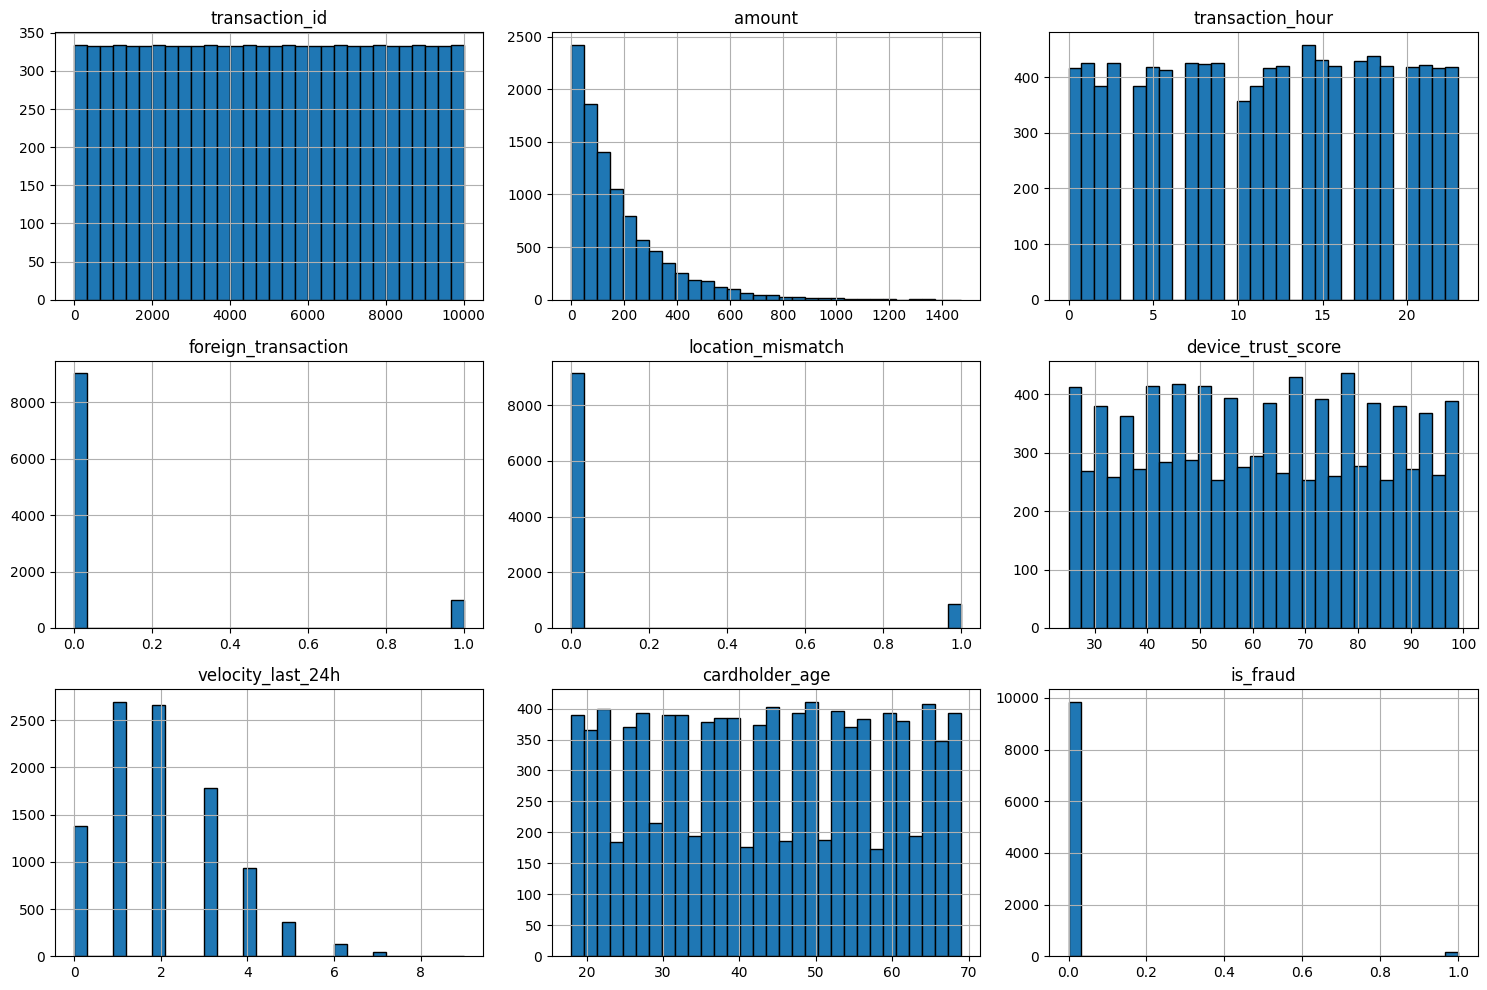

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical fetures
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Plot Histogram
df[numerical_cols].hist(bins=30, figsize=(15, 10), layout=(-1, 3), edgecolor='black')
plt.tight_layout()
plt.show()

### 1.Financial Behavior

- **Amount** : The Trend is"right-skewed." Most transactions are small amounts (under $200), and as the price goes up, the number of transactions drops off significantly. High-value transactions are rare.

- **Velocity_last_24h** : Most people make 1 or 2 transactions a day. If this number is very high (like 8 or 9), it could indicate "card testing" or a spending spree by a fraudster.



### 2. Contextual/Risk Factors

- **Foreign_transaction** (0,1) :

  0 = Domestic
  1 = International

  The vast majority of transactions are domestic (at 0.0). Only a small fraction are international.


- **Location_mismatch** (0, 1) : refers to when the card’s registered location is different from where the transaction is happening.

  0 = No mismatch. The transaction location matches the cardholder's home area.

  1 = A mismatch. The purchase is happening somewhere unexpected.

  Similar to foreign transactions, most transactions happen in a "normal" location. A mismatch (at 1.0) is a rare event and often a red flag for fraud.



- **Transaction_hour** : People are buying things at all hours of the day and night, though you can see slight dips—likely during the late-night/early-morning hours.


- **is_fraud** : This is a classic imbalanced dataset. The huge bar at 0.0 shows that almost all transactions are legitimate. The tiny sliver at 1.0 represents the rare fraud cases that the system is trying to catch.

### 3.Demographics & Device

- **cardholder_age** : This dataset has a very even (uniform) distribution of ages, from roughly 18 to 70. It shows the data isn't biased toward just young or just old people.

- **device_trust_score** : This is widely distributed between 25 and 100.


In [10]:
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


In [11]:
df = df.drop('transaction_id', axis=1)

In [12]:
df.head()

,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,84.47,22,Electronics,0,0,66,3,40,0
1,541.82,3,Travel,1,0,87,1,64,0
2,237.01,17,Grocery,0,0,49,1,61,0
3,164.33,4,Grocery,0,1,72,3,34,0
4,30.53,15,Food,0,0,79,0,44,0


In [13]:
# Split numerical columns into dataframe

df_numeric = df.select_dtypes(include=['number'])

# Show all numerical columns
print("Numerical columns :")
print(df_numeric.columns.tolist())

print(df_numeric.head())

Numerical columns :
['amount', 'transaction_hour', 'foreign_transaction', 'location_mismatch', 'device_trust_score', 'velocity_last_24h', 'cardholder_age', 'is_fraud']
   amount  transaction_hour  foreign_transaction  location_mismatch  \
0   84.47                22                    0                  0   
1  541.82                 3                    1                  0   
2  237.01                17                    0                  0   
3  164.33                 4                    0                  1   
4   30.53                15                    0                  0   

   device_trust_score  velocity_last_24h  cardholder_age  is_fraud  
0                  66                  3              40         0  
1                  87                  1              64         0  
2                  49                  1              61         0  
3                  72                  3              34         0  
4                  79                  0              44    

In [14]:
# Comparison of Mean between Class 0(Normal) and 1(Fraud)
print("\n--- Mean ---")
df_numeric.groupby('is_fraud').mean()



--- Mean ---


,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age
is_fraud,,,,,,,
0,175.333015,11.712154,0.090974,0.079704,62.165804,1.990557,43.469794
1,216.182980,3.841060,0.543046,0.476821,37.867550,3.205298,43.397351


In [15]:
# Comparison of Variance between Class 0(Normal) and 1(Fraud)
df_var = df_numeric.groupby('is_fraud').var()
print("\n--- Variance ---")
display(df_var.round(2))


--- Variance ---


,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age
is_fraud,,,,,,,
0,30271.42,47.21,0.08,0.07,455.87,2.00,224.62
1,61563.77,33.68,0.25,0.25,261.77,3.82,209.99


In [16]:
#Comparison of Standard Deviation between Class 0(Normal) and 1(Fraud)
df_std = df_numeric.groupby('is_fraud').std()
print("\n---Standard Deviation---")
display(df_std.round(2))


---Standard Deviation---


,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age
is_fraud,,,,,,,
0,173.99,6.87,0.29,0.27,21.35,1.42,14.99
1,248.12,5.80,0.50,0.50,16.18,1.95,14.49


### Interpretation of Mean and Standard Diviation

🚩 The "High Alert" Features

Based on the descriptive statistics, Here are the most suspicious columns that would likely have high Feature Importance in a fraud detection model.

    ⚠ transaction_hour  : There is a massive drop from 11.71 (Normal) to 3.84 (fraud) with low spread . This suggests fraud is heavily concentrated in the early morning hours.

    ⚠ device_trust_score : Legitimate transactions have a much higher average trust score (62.17) compared to fraudulent ones (37.87).

    ⚠ velocity_last_24h : Fraud shows a higher frequency of transactions (3.21) compared to normal users (1.99).

    ⚠ foreign_transaction and	location_mismatch	: Fraud shows a higher tendency to happend out of range or international.

From the figure, Data is extremely imbalanced.

In [17]:
# Show only fraud transaction
df_fraud_only = df[df['is_fraud'] == 1]

# Show a number of normal transaction
df_normal_only = df[df['is_fraud'] == 0]

In [18]:
df_fraud_only.shape

(151, 9)

In [19]:
df_normal_only.shape

(9849, 9)

/tmp/ipython-input-364/3442132829.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_normal_only['amount'], label='Normal', shade=True, color='blue')
/tmp/ipython-input-364/3442132829.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_fraud_only['amount'], label='Fraud', shade=True, color='red')


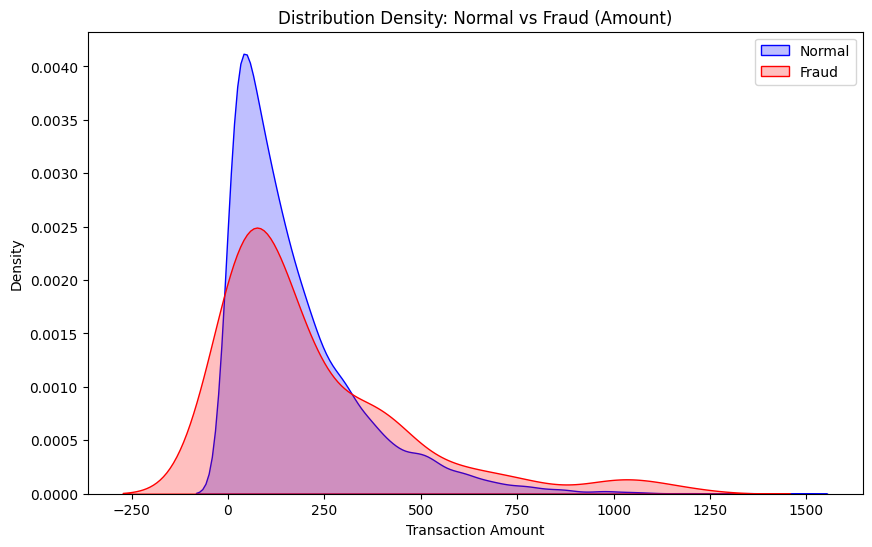

In [20]:
plt.figure(figsize=(10, 6))

# Compare Amount of transaction by classes
sns.kdeplot(df_normal_only['amount'], label='Normal', shade=True, color='blue')
sns.kdeplot(df_fraud_only['amount'], label='Fraud', shade=True, color='red')

plt.title('Distribution Density: Normal vs Fraud (Amount)')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipython-input-364/1524280049.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='amount', y='is_fraud', orient='h', palette='Set2')


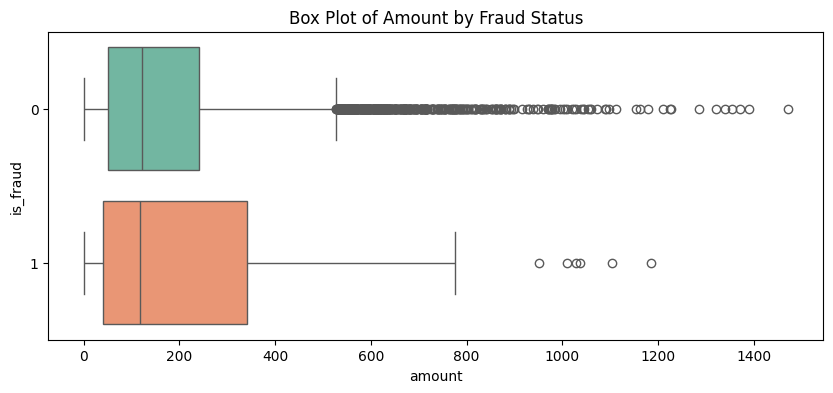

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='amount', y='is_fraud', orient='h', palette='Set2')
plt.title('Box Plot of Amount by Fraud Status')
plt.show()


1. Mean & Range
- ธุรกรรมปกติ (0): มีค่าเฉลี่ยอยู่ที่ประมาณ 175 โดยส่วนใหญ่อยู่ในช่วงไม่เกิน 250

- ธุรกรรมทุจริต (1): มีค่าเฉลี่ยสูงกว่าเล็กน้อยที่ประมาณ 216 และมีความผันผวน SD สูงกว่าด้วย
**Fraud มีทั้งยอดที่เล็กมาก ๆ และยอดที่ใหญ่กว่าปกติ**
มีความแปรปรวน (SD) สูงมาก เพราะโจรไม่มีรูปแบบที่แน่นอนเหมือนคนปกติ

1. Mean & Range

Non-Fraud Transactions (0):
The average transaction amount is approximately 175, with most transactions falling below 250.

Fraud Transactions (1):
The average amount is slightly higher, around 216, and the group exhibits a higher standard deviation (SD), indicating greater variability.

Fraudulent transactions include both very small amounts and unusually large amounts.
The variance (SD) is considerably higher because fraudulent behavior does not follow a consistent spending pattern like normal transactions.


2. Distribution Shape
- ทั้งสองกลุ่มมีลักษณะเป็น Right-Skewed เบ้ขวา เหมือนกัน คือคนส่วนใหญ่ (รวมถึงโจร) **นิยมทำรายการยอดเงินน้อยมากกว่า ยอดเงินสูง**

สังเกตว่าช่วง 0-200 มีความทับซ้อน (Overlap) กันสูงมาก นั่นแปลว่า Amount เพียงอย่างเดียวอาจจะแยก Fraud ไม่ออก (พฤติกรรมการใช้เงินของคนปกติกับมิจฉาชีพในช่วงราคานี้ เหมือนกันจนแยกไม่ออก)

2. Distribution Shape

Both groups show a right-skewed distribution, meaning that most transactions (including fraudulent ones) tend to involve smaller amounts rather than larger amounts.

There is significant overlap in the 0–200 range, suggesting that transaction amount alone may not be sufficient to distinguish fraudulent transactions.
In this range, the spending behavior of legitimate users and fraudsters appears very similar, making classification based solely on amount difficult.

In [ ]:
# @title
# สร้างช่วงเวลา 4 ช่วงวลา เช้า กลางวัน เย็น กลางคืน
'''

# ---------------------------------------------------------
# เทคนิคที่ 1: Time Binning (สร้างคอลัมน์ช่วงเวลา)
# ---------------------------------------------------------
# ขยับ bins ใหม่ให้เป็น 0, 6, 12, 18, 24
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# เพิ่ม right=False เข้าไป
# (ความหมายคือ: เอาตัวเลขซ้าย แต่ไม่เอาตัวเลขขวา)
# Night     = 0, 1, 2, 3, 4, 5
# Morning   = 6, 7, 8, 9, 10, 11
# Afternoon = 12, 13, 14, 15, 16, 17
# Evening   = 18, 19, 20, 21, 22, 23
df['time_of_day'] = pd.cut(df['transaction_hour'], bins=bins, labels=labels, right=False)

# ลองเช็คผลลัพธ์ดูครับ
print(df[['transaction_hour', 'time_of_day']].head(10))

'''

In [ ]:
# @title
'''
import matplotlib.pyplot as plt

# 1. นับจำนวน Transaction ในแต่ละช่วงเวลา
time_counts = df['time_of_day'].value_counts()

# 2. สร้างกราฟวงกลม (Pie Chart)
plt.figure(figsize=(8, 8)) # กำหนดขนาดของกราฟ
plt.pie(time_counts,
        labels=time_counts.index,   # ชื่อของแต่ละส่วน (Night, Morning, Afternoon, Evening)
        autopct='%1.1f%%',          # แสดงตัวเลขเปอร์เซ็นต์ (ทศนิยม 1 ตำแหน่ง)
        startangle=90,              # หมุนจุดเริ่มต้นของกราฟไปที่ 90 องศา (ด้านบนสุด)
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], # กำหนดสี (เปลี่ยนได้ตามต้องการ)
        wedgeprops={'edgecolor': 'black'} # เพิ่มเส้นขอบสีดำให้กราฟดูชัดเจนขึ้น
       )

# 3. ใส่ชื่อกราฟและตั้งค่าให้เป็นวงกลมสมมาตร
plt.title('Proportion of Transactions by Time of Day', fontsize=16)
plt.axis('equal') # บังคับให้กราฟเป็นวงกลมกลมดิก (ไม่เป็นวงรี)

# 4. แสดงกราฟ
plt.show()

'''


In [22]:
import numpy as np

# 1. จัดการคอลัมน์ amount ที่มีความเบ้สูงและมี Outliers มาก
# ค่า SD ของกลุ่ม Fraud (248.12) สูงกว่า Mean (216.18) อย่างชัดเจน
df['amount'] = np.log1p(df['amount'])

# 2. จัดการคอลัมน์ velocity_last_24h ที่มีการกระจายตัวแบบเบ้ขวา
df['velocity_last_24h'] = np.log1p(df['velocity_last_24h'])

# หมายเหตุ:
# - เราใช้ np.log1p เพื่อป้องกัน Error ในกรณีที่ข้อมูลมีค่าเป็น 0
# - คอลัมน์อื่นๆ เช่น transaction_hour หรือ binary flags ไม่จำเป็นต้องทำ Log Transformation

# ตรวจสอบค่าทางสถิติเบื้องต้นหลังแปลงข้อมูล
print(df[['amount', 'velocity_last_24h']].describe())

             amount  velocity_last_24h
count  10000.000000       10000.000000
mean       4.626002           0.978593
std        1.208247           0.517219
min        0.000000           0.000000
25%        3.949415           0.693147
50%        4.812956           1.098612
75%        5.495035           1.386294
max        7.294404           2.302585


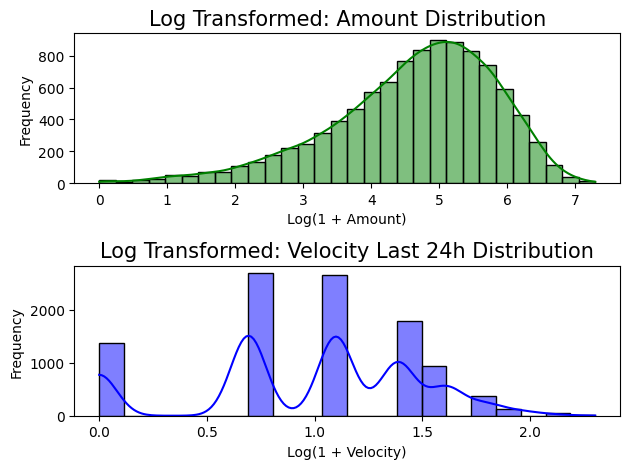

In [23]:
plt.subplot(2, 1, 1)
sns.histplot(df['amount'], kde=True, color='green', bins=30)
plt.title('Log Transformed: Amount Distribution', fontsize=15)
plt.xlabel('Log(1 + Amount)')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
sns.histplot(df['velocity_last_24h'], kde=True, color='blue', bins=20)
plt.title('Log Transformed: Velocity Last 24h Distribution', fontsize=15)
plt.xlabel('Log(1 + Velocity)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

เนื่องจากตัวแปร amount และ velocity_last_24h มีการกระจายตัวแบบเบ้ขวารุนแรง (Highly Skewed) และมีค่าผิดปกติ (Outliers) จำนวนมาก เราจึงทำการแปลงข้อมูลด้วย Log Transformation ($\log(1+x)$)
เพื่อปรับการกระจายตัวให้มีความสมมาตรมากขึ้น ช่วยลดอิทธิพลของค่าสุดโต่ง และเพิ่มความเสถียร (Numerical Stability) ให้กับโมเดลในการเรียนรู้ความสัมพันธ์ของข้อมูล

Since the variables amount and velocity_last_24h exhibit a highly right-skewed distribution and contain a substantial number of outliers, we applied a log transformation using log(1+x).
This transformation helps make the distribution more symmetric, reduces the influence of extreme values, and improves the numerical stability of the model when learning patterns and relationships within the data.


##Encoding Quanlitative Columns ( merchant_category, time_of_day )

In [24]:
df.head()

,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,4.448165,22,Electronics,0,0,66,1.386294,40,0
1,6.296778,3,Travel,1,0,87,0.693147,64,0
2,5.472313,17,Grocery,0,0,49,0.693147,61,0
3,5.107943,4,Grocery,0,1,72,1.386294,34,0
4,3.450939,15,Food,0,0,79,0.000000,44,0


In [25]:
# Use pd.get_dummies convert merchant_category column into dummy variable.
df = pd.get_dummies(
    df,
    columns=['merchant_category'],
    drop_first=True,
    dtype=int        # Prevent being object
)

In [26]:
df.head()

,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel
0,4.448165,22,0,0,66,1.386294,40,0,1,0,0,0
1,6.296778,3,1,0,87,0.693147,64,0,0,0,0,1
2,5.472313,17,0,0,49,0.693147,61,0,0,0,1,0
3,5.107943,4,0,1,72,1.386294,34,0,0,0,1,0
4,3.450939,15,0,0,79,0.000000,44,0,0,1,0,0


In [27]:
# @title
#from google.colab import sheets
#sheet = sheets.InteractiveSheet(df=df)

In [28]:
print(df.columns.tolist())

['amount', 'transaction_hour', 'foreign_transaction', 'location_mismatch', 'device_trust_score', 'velocity_last_24h', 'cardholder_age', 'is_fraud', 'merchant_category_Electronics', 'merchant_category_Food', 'merchant_category_Grocery', 'merchant_category_Travel']


### Log Transformation

# XGboost ✨
$$scale\_pos\_weight = \frac{\text{Total Negative Examples (Normal)}}{\text{Total Positive Examples (Fraud)}}$$

scale_pos_weight + Threshold Moving

# Split the data into 3 parts
- Test set
- Train set
- Validation

In [29]:
from sklearn.model_selection import train_test_split

In [30]:


# Split class from independent variables
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Let Test Set be 20%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Segment left data to Train 60% and Validation 20%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 0.25 of 0.80 is 0.20
    random_state=42,
    stratify=y_temp
)

print(f"Dataset is avaliable >> Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Dataset is avaliable >> Train: 6000 | Validation: 2000 | Test: 2000


In [31]:
X.head()


,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel
0,4.448165,22,0,0,66,1.386294,40,1,0,0,0
1,6.296778,3,1,0,87,0.693147,64,0,0,0,1
2,5.472313,17,0,0,49,0.693147,61,0,0,1,0
3,5.107943,4,0,1,72,1.386294,34,0,0,1,0
4,3.450939,15,0,0,79,0.000000,44,0,1,0,0


In [32]:
y.head()

,is_fraud
0,0
1,0
2,0
3,0
4,0


# Training Model 😮 💖

In [33]:
import xgboost as xgb

In [34]:
#Handling Imbalance (Weighting)
# 1. คำนวณค่าตัวถ่วงน้ำหนัก (scale_pos_weight)
negative_cases = (y_train == 0).sum()
positive_cases = (y_train == 1).sum()
weight = negative_cases / positive_cases
print(f"สัดส่วน scale_pos_weight ที่คำนวณได้: {weight:.2f}")

# 2. Perform XGBoost
model = xgb.XGBClassifier(
    scale_pos_weight=weight,
    eval_metric='aucpr',
    random_state=42,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=1000,
    early_stopping_rounds=50
)

# 3. Train model
print("\nTrainin Model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

print("\nTraining Succeeded! 🎉")

สัดส่วน scale_pos_weight ที่คำนวณได้: 64.93

Trainin Model...
[0]	validation_0-aucpr:0.95631	validation_1-aucpr:0.94453
[50]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99778
[100]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000
[107]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000

Training Succeeded! 🎉


## Evaluate Validation

=== Confusion Matrix (Validation Set) ===
[[1968    2]
 [   0   30]]


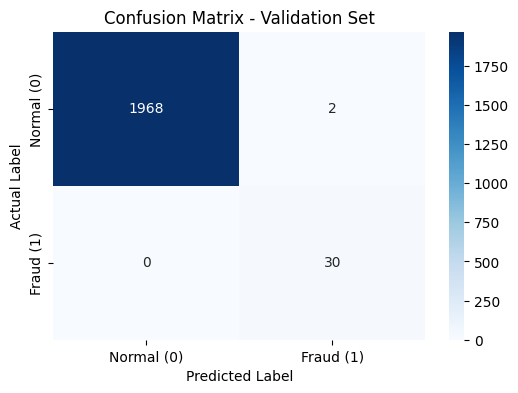

In [35]:
#To prevent model overfitting, Before apply the model to real dataset we have to evaluate accuracy through Confusion Matrix or AUC-ROC.
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# 1.Performs on the validation set
# ---------------------------Predict------------------------------
y_val_pred = model.predict(X_val)

# Predict the probability of Fraud transaction for AUC-ROC
y_val_prob = model.predict_proba(X_val)[:, 1]

# ---------------------------------------------------------
# 2. Confusion Matrix
# ---------------------------------------------------------
cm = confusion_matrix(y_val, y_val_pred)
print("=== Confusion Matrix (Validation Set) ===")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Fraud (1)'],
            yticklabels=['Normal (0)', 'Fraud (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()




=== AUC-ROC Score (Validation Set): 1.0000 ===


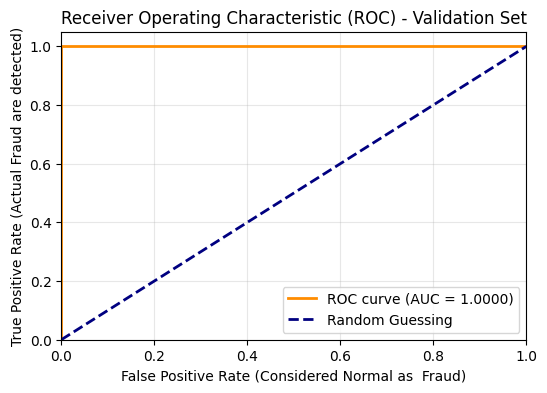

In [36]:

# ---------------------------------------------------------
# 3. คำนวณและพล็อตกราฟ ROC Curve (AUC-ROC)
# ---------------------------------------------------------
# คำนวณคะแนน AUC-ROC
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"\n=== AUC-ROC Score (Validation Set): {roc_auc:.4f} ===")

# คำนวณค่า FPR, TPR สำหรับวาดเส้นกราฟ
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Considered Normal as  Fraud)')
plt.ylabel('True Positive Rate (Actual Fraud are detected)')
plt.title('Receiver Operating Characteristic (ROC) - Validation Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify Feature Importances of the model
importances = model.feature_importances_
feature_names = X_train.columns

# 2. Perform to DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)



/tmp/ipython-input-364/2759866052.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Gly

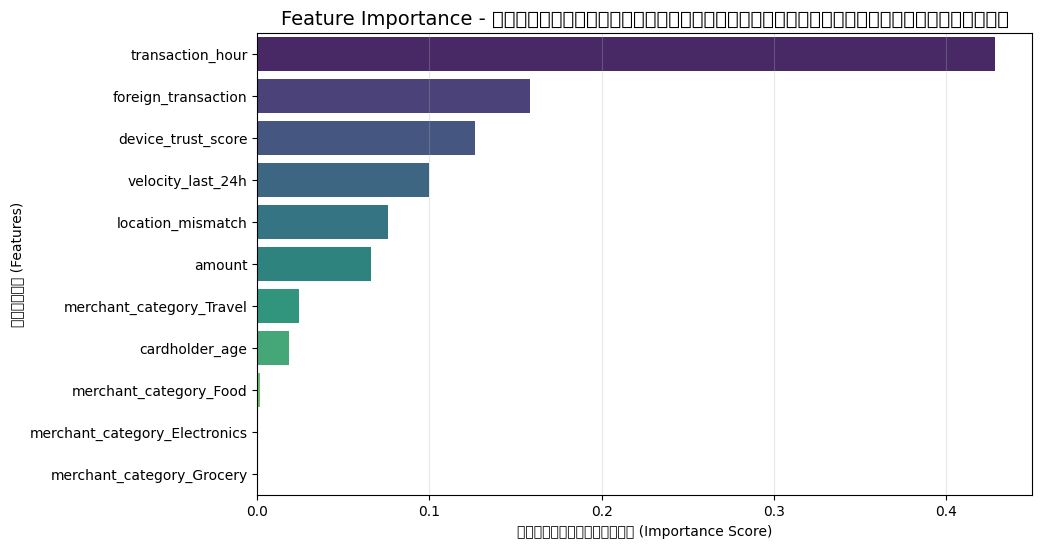


=== Feature Importance table ===


,Feature,Importance
1,transaction_hour,0.4286
2,foreign_transaction,0.1581
4,device_trust_score,0.1266
5,velocity_last_24h,0.0999
3,location_mismatch,0.0762
0,amount,0.0661
10,merchant_category_Travel,0.0245
6,cardholder_age,0.0183
8,merchant_category_Food,0.0018
7,merchant_category_Electronics,0.0000


In [38]:
# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - ตรวจสอบว่าโมเดลใช้ตัวแปรไหนตัดสินใจมากที่สุด', fontsize=14)
plt.xlabel('คะแนนความสำคัญ (Importance Score)')
plt.ylabel('ตัวแปร (Features)')
plt.grid(axis='x', alpha=0.3)
plt.show()

# Show
print("\n=== Feature Importance table ===")
display(importance_df.round(4))

1. Confusion Matrix
(TN) ทายถูกว่าปกติ = 1968
(FP) ทายว่า Fraud แต่จริงๆ ไม่ = 2
(FN) ทายว่าปกติ แต่จริงๆ Fraud = 0
(TP) ทายถูกว่า Fraud = 30
- Recall (Sensitivity): วัดว่า จากรายการที่โกงทั้งหมด Model ตรวจเจอได้กี่เปอร์เซ็นต์
ถ้า False Negative (FN) สูง = Model เรา "ตาถั่ว" ปล่อยให้โจรขโมยเงินไปได้เยอะ

1. Confusion Matrix
True Negative (TN): Correctly predicted as normal = 1,968
False Positive (FP): Predicted as fraud but actually normal = 2
False Negative (FN): Predicted as normal but actually fraud = 0
True Positive (TP): Correctly predicted as fraud = 30
- Recall (Sensitivity): Recall measures the percentage of actual fraudulent transactions that the model correctly identifies.
If the False Negative (FN) value is high, it means the model fails to detect many fraudulent cases — effectively allowing fraudsters to go undetected.

2. ROC
- AUC = 1.0: คือ Perfect Model (Model ในอุดมคติ) ที่สามารถแยกคนปกติกับโจรออกจากกันได้อย่างเด็ดขาด ไม่มีความผิดพลาดเลย
- กราฟที่วิ่งไปจนถึงมุมบนซ้าย (Top-Left corner) ทันที แสดงว่า Model สามารถทำค่า Recall (จับโจร) ได้ถึง 100% โดยที่แทบจะไม่ต้องยอมแลกกับ False Positive (จับคนปกติผิด) เลย

2. ROC Curve
- AUC = 1.0 indicates a perfect model — one that completely separates legitimate transactions from fraudulent ones without any classification error.
- A ROC curve that immediately rises to the top-left corner suggests that the model achieves 100% recall (detects all fraud cases) while maintaining an extremely low false positive rate (i.e., it rarely misclassifies normal transactions as fraud).



In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# คำนวณค่า Metrics ต่างๆ
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

# แสดงผลลัพธ์
print("=== สรุปประสิทธิภาพของโมเดลบน Validation Set ===")
print(f"Accuracy (overall performance) : {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")
print(f"Precision (the quality of the model’s positive predictions Fraud) : {precision_val:.4f} ({precision_val*100:.2f}%)") # Tell us how many of the "positive" predictions were actually correct
print(f"Recall (the proportion of true positives detected)  : {recall_val:.4f} ({recall_val*100:.2f}%)") # How good the model is at predicting positives.
print(f"F1-Score  : {f1_val:.4f} ({f1_val*100:.2f}%)") # It provides a better sense of a model’s overall performance particularly for imbalanced datasets

=== สรุปประสิทธิภาพของโมเดลบน Validation Set ===
Accuracy (overall performance) : 0.9990 (99.90%)
Precision (the quality of the model’s positive predictions Fraud) : 0.9375 (93.75%)
Recall (the proportion of true positives detected)  : 1.0000 (100.00%)
F1-Score  : 0.9677 (96.77%)


ทำไมทายถูกหมดเลย


- Recall = 1.0000 (100%): ไม่มีรายการทุจริตเล็ดลอดสายตาโมเดลนี้ไปได้เลย (Zero False Negatives) ในทางธุรกิจคือธนาคารหรือร้านค้าจะไม่เสียเงินให้มิจฉาชีพเลยจากข้อมูลชุดนี้

- Precision = 0.9375 (93.75%): หมายความว่าในการแจ้งเตือน 100 ครั้ง และมี "การแจ้งเตือนผิด" (False Positive) ประมาณ 6 ครั้งจะเป็นการทุจริตจริง 94 ครั้ง

- Accuracy = 99.90%: สูงมากตามคาด เพราะข้อมูลส่วนใหญ่เป็นรายการปกติ

- Recall = 1.0000 (100%) : This indicates that no fraudulent transactions were missed by the model (zero false negatives).

  From a business perspective, this means that the bank or merchant would not lose money to fraudsters within this dataset.

- Precision = 0.9375 (93.75%) : This means that out of every 100 fraud alerts generated by the model, approximately 94 cases are actual fraud, while about 6 cases are false positives.

- Accuracy = 99.90% : The overall accuracy is extremely high, which is expected because the dataset is highly imbalanced, with the majority of transactions being legitimate.




 ✅ The statistical patterns confirm that the model is capturing genuine fraudulent behavior rather than overfitting to noise. By aligning the Feature Importance rankings with our initial Comparison of Means, we can verify that the model successfully prioritized the specific behavioral signatures.


**สรุปปัจจัยที่มีผลต่อการตัดสินใจของโมเดล**
1. The Key Drivers
- transaction_hour (0.4286): (ครองสัดส่วนเกือบ 43% ของการตัดสินใจทั้งหมด)
ในชุดข้อมูลนี้ "เวลา" คือตัวแยกแยะที่ชัดเจนที่สุด เป็นไปได้ว่า Fraud ในข้อมูลชุดนี้เกิดขึ้นในเวลาที่คนปกติไม่ค่อยใช้งานกัน หรือเกิดขึ้นเป็นแพทเทิร์นเวลาที่เฉพาะเจาะจงมาก

- foreign_transaction (0.1581): การทำรายการจากต่างประเทศยังคงเป็นสัญญาณเตือน (Red Flag) ที่สำคัญมากในการตรวจจับทุจริต

- transaction_hour (0.4286): This feature accounts for nearly 43% of the total decision importance, making it the most influential variable in the model.

This suggests that fraudulent activities may occur during unusual hours when normal users are less active, or follow very specific time-based patterns.

- foreign_transaction (0.1581): Transactions conducted from foreign locations remain a significant red flag for fraud detection.


2. กลุ่ม Merchant Category (ข้อมูลหมวดหมู่ร้านค้า)
จะเห็นว่ามีการทำ One-Hot Encoding ออกมาเป็นแต่ละหมวดหมู่:
- Travel (0.0245): มีผลมากกว่าหมวดอื่น ๆ เล็กน้อย
- Grocery / Electronics (≈ 0.00): แทบไม่มีผลต่อโมเดลเลย

การรูดบัตรเกี่ยวกับ Travel อาจจะมีความเสี่ยงสูงกว่าในมุมมองของโมเดลนี้

The merchant category variable was transformed using One-Hot Encoding, resulting in separate binary features for each category.

- Travel (0.0245): This category has slightly higher importance compared to others
- Grocery / Electronics (≈ 0.00): These categories contribute almost no importance to the model.

Transactions related to travel may carry a relatively higher risk from the model’s perspective.


จากการศึกษาความสำคัญของตัวแปร (Feature Importance) พบว่า ช่วงเวลาที่ทำรายการ (transaction_hour) เป็นปัจจัยที่มีผลต่อการพยากรณ์สูงสุด รองลงมาคือ การทำธุรกรรมจากต่างประเทศ (foreign_transaction) และ คะแนนความน่าเชื่อถือของอุปกรณ์ (device_trust_score) ตามลำดับ

ในขณะที่ปัจจัยด้านข้อมูลส่วนบุคคล เช่น อายุของผู้ถือบัตร (cardholder_age) และ หมวดหมู่ร้านค้า (merchant_category) ส่วนใหญ่มีผลต่อการตัดสินใจของโมเดลน้อยมาก ซึ่งสะท้อนให้เห็นว่าพฤติกรรมการใช้งานที่ผิดปกติในเชิงบริบท (เวลาและสถานที่) มีนัยสำคัญในการตรวจจับการทุจริตมากกว่าข้อมูลพื้นฐานของผู้ใช้งาน.

Feature importance analysis shows that transaction hour has the strongest impact on prediction, followed by foreign transactions and device trust score.

In contrast, personal attributes such as cardholder age and merchant category have minimal influence. This suggests that contextual behavioral patterns (time and location) are more critical for fraud detection than users’ basic demographic information.

# Pipeline (Improving....)

In [42]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [43]:
# Data prepocessing
log_features = ['amount', 'velocity_last_24h']
categorical_features = ['merchant_category']

# 2. สร้างตัวจัดการข้อมูล (Preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), log_features),
        ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # เก็บ Column อื่นๆ ไว้เหมือนเดิม
)

# 3. มัดรวมเป็น Pipeline
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model) # ใส่โมเดล XGBoost ที่คุณเทรนเสร็จแล้วลงไป
])

pipelines = {"XGBClassifier": best_pipeline}

In [44]:
test_try = df = pd.read_csv('/content/gdrive/MyDrive/Business & Data Sci/Test_try.csv')
display(df.head())

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


# Testing a model with 20% of a dataset  ❌

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
'''
# 1. Perform the model on Test set
print("\nExecuting Test Set...")
y_pred = model.predict(X_test)

# 2.Probability of class 1 ( Fraud )
y_pred_proba = model.predict_proba(X_test)[:, 1]

'''



In [ ]:
'''
# 3. Evaluate on Test set
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
'''